In [1]:
import datetime  
from datetime import date , timedelta
import os 
import re 
from bs4 import BeautifulSoup 
import pandas as pd 
from sklearn.impute import KNNImputer 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from matplotlib import colors 
from scipy.stats import spearmanr 
import statsmodels.api as sm 
from scipy.stats import kstest
from scipy.stats import mannwhitneyu

from sklearn.model_selection import train_test_split 
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA 
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error 

# Introduction to code layout

The code begins by first generating the possible filenames given a date range. If a file exists, it is opened, and the data is attached to a dictionary. Next, we proceed to webscrape each html section. Two attempts are tried given that there two different html formats. When the property description section is identified, the data is extracted through the use of several regex. Cleaning on this data is also performed and it is attached to a list. Once the data is collected, we drop the empty fields, and impute the rest, we then write this data to the csv. </br>

After, 3 visuals and one stats test are presented as 'proof' to statements made about this data. Before each visual is the processing of the required data to generate it. After which a correlation is identified and proved through another statistical test. After another statistical test, required by the task 3e is done. After which the predictive model is then created. Each section is clearly labelled. 

# Get File Content 

In [2]:
def get_data_from_files(): #open and store the data from the html files 

    filename_ext = "_prop_for_sale_tom_classifieds.html"
    cwd = os.getcwd()

    start_date = date(2015, 4, 23) #time range considered 
    end_date = date(2022, 11, 16)
    
    date_format = '%Y%m%d' #forma and whole time frame 
    delta = end_date - start_date 

    data = []  

    for i in range(delta.days + 1): 
        
        day = start_date + timedelta(days=i) #day ranges
        day_formatted = day.strftime(date_format) #required format 
        
        filename = str(day_formatted)+filename_ext 
        full_path = str(cwd) + "/data/" + filename #full path to file 

        try: #attempt to open file 
            file = open(full_path, "r") 
            data.append({"file" : filename, "html" : file.read()})
        except:
            continue 

    return data 

In [3]:
file_data = get_data_from_files() 

# Regex For Cleaning 

In [4]:
#regex's 
price_re = r'€\d+(,\d+)*' # match euro, (1 or more digits), define a capture group including comma and 1-inf digits. Match this group 0 - inf times 
extract_price_re = r'(\d+(,\d+)|\d+)'

number = '(zero|one|two|three|third|four|five|six|seven|eight|nine|ten){1}' #digits match exactly one 
digit_re = re.compile(number, re.IGNORECASE)


double = '( double|double){0,1}' #match double 0 or 1 times 
bedroom = '(bedroom| bedroom){1}' #match bedrooms 1 (account for space)
bedroom_re = re.compile(number+double+bedroom, re.IGNORECASE)

garage_re = re.compile('garage', re.IGNORECASE)


sqm = '\d+(,\d+)*'
sqm_re = re.compile(sqm+'(sqm| sqm)', re.IGNORECASE)

house_type = '(penthouse|terraced|maisonette|flat|apartment|villa|townhouse|palazzo|bungalow|house|field|industrial|restaurant|shop)'
house_type_re = re.compile(house_type, re.IGNORECASE)

#extra house features 
state = '(furnished|seaview|seafront|sea-view|sea view|sea front|sea-front|finished|terrace|pool|balconies|detached|yard)'
state_re = re.compile(state, re.IGNORECASE)

#catch Property for sale, 2 or more capital letters and some exceptions, and stop and don t include the last group (pos lookahead)
place_re = re.compile('(Property For Sale|\n| )*([A-Z]| |\'|Ġ|Ż|Ħ|À|-|Ċ|È){2,}(?=([a-z]|,|.)){1,}')

# Helper Functions 

In [5]:
def change_to_digit(number_chars):#helper function 
    standard = str(number_chars).lower() 
    
    if(standard == 'one'):
        return 1 
    elif(standard == 'two'):
        return 2
    elif(standard == 'three'):
        return 3
    elif(standard == 'four'):
        return 4
    elif(standard == 'five'):
        return 5 
    elif(standard == 'six'):
        return 6
    elif(standard == 'seven'):
        return 7
    elif(standard == 'eight'):
        return 8
    elif(standard == 'nine'):
        return 9 
    elif(standard == 'ten'):
        return 10 
    elif(standard == 'zero'):
        return 0
    else:
        return None

#function to handle empty files 
def check_for_empty_file(file_name):
    cwd = os.getcwd() 
    full_path = str(cwd) + '/data/' + file_name
    file_stats = os.stat(full_path) #get stats about the file 
    
    if(file_stats.st_size == 0): #check for size 
        print(file_name, " is 0 bytes")
        return True
    else:
        return False 

def handle_cleaning(text): #Data Cleaning function 
    
    #perform all the regex 
    price = re.search(price_re, text)
    bedrooms = re.search(bedroom_re, text)
    garage_ret = re.search(garage_re, text)
    sqm = re.search(sqm_re, text)
    house_type = re.search(house_type_re, text)
    extras = re.search(state_re, text)
    place = re.search(place_re, text)
    
    cost = None 
    bedroom = None 
    size = None 
    house = None 
    features = "N/A" 
    town = None 
    garage = False 
    
    #Handle each regex return 
    
    if(price != None): 
        res = re.search(extract_price_re, price.group()) #get actual price 
        actual_price = res.group() 
        cost = int(actual_price.replace(",","")) #remove the commas 
        
        
        if (cost < 15000 or cost > 50000000):#expecting property to fall in this range 
            cost = None 
                
 
    if(bedrooms != None):
        res = re.search(digit_re, bedrooms.group()) #get the digit only 
        bedroom = change_to_digit(res.group())
        

    if(garage_ret != None):  
        garage = True 


    if(sqm != None):
        size = sqm.group()

    if(house_type != None):
        house = house_type.group().lower()

    if(extras != None):
        features = extras.group().lower()


    if(place != None):
        remove = place.group().replace('Property For Sale', "") #clean string 
        final = remove.replace('\n', "")
        if(len(final)>2 and 'RESTAURANT' not in final and 'APARTMENTS' not in final 
           and 'PROPERTY' not in final and 'FLOOR' not in final): #handle exceptions 
            town = final.lower().strip() 
            
    #when main features of the property are missing, we do not consider this entry 
    if(cost == None and bedroom == None and size == None and house == None and town == None):
        return None 
    
    house_data = {'cost(€)' : cost, 'bedrooms' : bedroom, 'size' : size, 'house' : house,
                  'extras' : features, 'town' : town, 'garage' : garage} #data dict 
    
    return house_data 


# WebScraping + Cleaning 

In [6]:
data = [] 

for i in range(len(file_data)):  
    year = re.search(r'\w\w\w\w', file_data[i]['file']) #find the year of the listed property (from file)
    soup = BeautifulSoup(file_data[i]['html'], "html.parser") #scraper 
    score = 0
    
    try:       
         # get main section content of the page 
        main_content = soup.body.find('div', {'id' : "section_section"}).find_all('ul')


        for ul in main_content:
            for property_cont in ul.find_all('p'): #filter out the required text 
                
                
                ret = handle_cleaning(property_cont.text) #clean the data 
                if (ret == None): 
                    continue 
                    
                ret.update({'year' : int(year.group())}) #add the year
                data.append(ret)
                
    except:       
        ret = check_for_empty_file(file_data[i]['file'])
        if(ret == True): #skip over empty files 
            continue 
            
            
        main_cont = soup.body.find('div', {'class': "ca-Classifieds_Body"}).find_all('ul')
        for ul in main_cont: 
            for property_field in ul.find_all('li'):
                
                ret = handle_cleaning(property_field.text) #clean the data 
                if (ret == None): 
                    continue 
                
                ret.update({'year' : int(year.group())}) #add the year
                data.append(ret)     
            
print("Entries Found: ", len(data))   

20170425_prop_for_sale_tom_classifieds.html  is 0 bytes
20170620_prop_for_sale_tom_classifieds.html  is 0 bytes
20170704_prop_for_sale_tom_classifieds.html  is 0 bytes
20170713_prop_for_sale_tom_classifieds.html  is 0 bytes
20180919_prop_for_sale_tom_classifieds.html  is 0 bytes
Entries Found:  136932


In [7]:
df = pd.DataFrame(data)
display(df)

cost(€)  bedrooms    size       house    extras        town  garage  \
0       152000.0       3.0    None   apartment  finished      balzan   False   
1       185000.0       NaN    None    terraced   terrace        gozo   False   
2       293000.0       NaN    None       house      pool        gozo   False   
3       145000.0       NaN    None  maisonette       N/A        gozo   False   
4        85000.0       2.0    None   apartment  finished  marsascala   False   
...          ...       ...     ...         ...       ...         ...     ...   
136927  575000.0       3.0    None   townhouse  sea view    valletta   False   
136928   55000.0       NaN  500sqm        None       N/A      żebbuġ   False   
136929  245000.0       3.0    None   apartment       N/A      żebbuġ   False   
136930  250000.0       3.0    None  maisonette      yard      żejtun   False   
136931  830000.0       NaN  300sqm        None       N/A  st julians   False   

        year  
0       2015  
1       2015  
2       2015  
3       2015  
4       2015  
...      ...  
136927  2022  
136928  2022  
136929  2022  
136930  2022  
136931  2022  

[136932 rows x 8 columns]

# Null Handling & Imputation

In [8]:
for col in df.columns:
    col_na_count = df[col].isna().sum()
    col_size = len(df[col])
    
    print("Percentage of Nulls for ",col, " : ", (col_na_count/col_size)*100 )
    
#As a note N/A in extras is not a considered a null, but rather a house with no 'special' features 

Percentage of Nulls for  cost(€)  :  16.432243741419096
Percentage of Nulls for  bedrooms  :  23.12315601904595
Percentage of Nulls for  size  :  79.70452487365992
Percentage of Nulls for  house  :  6.470364852627582
Percentage of Nulls for  extras  :  0.0
Percentage of Nulls for  town  :  1.7906698215172494
Percentage of Nulls for  garage  :  0.0
Percentage of Nulls for  year  :  0.0


### Size is about 80% missing, we will drop this field. Rest of the data is then imputed using KNN imputation, since knn supports all types of data types (ordinal, categorical, continous). As a note N/A in extras is NOT counted as null but rather a house without extra features. 

In [9]:
df_clean = df.drop(columns=['size'])
display(df_clean)

cost(€)  bedrooms       house    extras        town  garage  year
0       152000.0       3.0   apartment  finished      balzan   False  2015
1       185000.0       NaN    terraced   terrace        gozo   False  2015
2       293000.0       NaN       house      pool        gozo   False  2015
3       145000.0       NaN  maisonette       N/A        gozo   False  2015
4        85000.0       2.0   apartment  finished  marsascala   False  2015
...          ...       ...         ...       ...         ...     ...   ...
136927  575000.0       3.0   townhouse  sea view    valletta   False  2022
136928   55000.0       NaN        None       N/A      żebbuġ   False  2022
136929  245000.0       3.0   apartment       N/A      żebbuġ   False  2022
136930  250000.0       3.0  maisonette      yard      żejtun   False  2022
136931  830000.0       NaN        None       N/A  st julians   False  2022

[136932 rows x 7 columns]

### We define some functions to encode and decode a categorical column in our df 

In [10]:
def encode_field(col): #returns a mapping to categorical column 
    
    mapped_val = 0 
    mapping = {}
    
    for entry in col.iteritems(): 
        if(entry[1] not in mapping.keys() and entry[1] != None):
            mapping.update({entry[1] : mapped_val}) #add to mapping 
            mapped_val += 1  
    
    return mapping             
        
def apply_map(df,col_name,mapping):
    copy_df = df.copy() #so we do not alter the original df 
     
    for index in range(len(df[col_name])):
        
        current_entry = df.at[index,col_name]
        
        if(current_entry != None): # we do not map the null's
            copy_df.at[index,col_name] = mapping[current_entry]
    
    return copy_df 

def decode_map(df,col_name,mapping):
    key_list = list(mapping.keys()) #extract the key value pairs 
    val_list = list(mapping.values())
    copy_df = df.copy()
    
    for index in range(len(df[col_name])):
        
        current_entry = df.at[index,col_name]
        if(current_entry != None):
            
            pos = val_list.index(current_entry) #get key position 
            copy_df.at[index,col_name] = key_list[pos] #return respective key 
        
    return copy_df 

In [11]:
house_mapping = encode_field(df_clean['house']) #get the encodings 
extras_mapping = encode_field(df_clean['extras'])
town_mapping = encode_field(df_clean['town']) 

mapped_house_df = apply_map(df_clean, 'house', house_mapping) #perform the encodings
mapped_extras_df = apply_map(mapped_house_df, 'extras', extras_mapping)
mapped_df = apply_map(mapped_extras_df, 'town', town_mapping)


#perform knn imputation 
imputer = KNNImputer(n_neighbors = 5, weights = 'uniform', missing_values=np.nan)
imputer.fit(mapped_df)
imputed = imputer.transform(mapped_df)

#fit back to df     
imputed_df = pd.DataFrame(imputed)
display(imputed_df)

0    1    2    3     4    5       6
0       152000.0  3.0  0.0  0.0   0.0  0.0  2015.0
1       185000.0  3.6  1.0  1.0   1.0  0.0  2015.0
2       293000.0  4.0  2.0  2.0   1.0  0.0  2015.0
3       145000.0  3.2  3.0  3.0   1.0  0.0  2015.0
4        85000.0  2.0  0.0  0.0   2.0  0.0  2015.0
...          ...  ...  ...  ...   ...  ...     ...
136927  575000.0  3.0  8.0  8.0  23.0  0.0  2022.0
136928   55000.0  3.2  2.4  3.0  11.0  0.0  2022.0
136929  245000.0  3.0  0.0  3.0  11.0  0.0  2022.0
136930  250000.0  3.0  3.0  6.0  78.0  0.0  2022.0
136931  830000.0  3.2  3.4  3.0  67.0  0.0  2022.0

[136932 rows x 7 columns]

### Decode back and write to CSV  

In [12]:
imputed_df[1] = np.floor(imputed_df[1])#floor cols 
imputed_df[2] = np.floor(imputed_df[2])
imputed_df[3] = np.floor(imputed_df[3])
imputed_df[4] = np.floor(imputed_df[4])

#rename the cols 
imputed_df.rename(columns = {0: 'cost_eur', 1: 'bedrooms', 2: 'house', 
                             3: 'extras', 4: 'town', 5: 'garage', 6:'year'}, inplace = True)

#decode 
unmapped_house = decode_map(imputed_df, 'house', house_mapping)
unmapped_extras = decode_map(unmapped_house, 'extras', extras_mapping)
data_df = decode_map(unmapped_extras, 'town', town_mapping)
data_df['garage'] = data_df['garage'].apply(lambda x: True if x==1.0 else False)

display(data_df)

cost_eur  bedrooms       house    extras        town  garage    year
0       152000.0       3.0   apartment  finished      balzan   False  2015.0
1       185000.0       3.0    terraced   terrace        gozo   False  2015.0
2       293000.0       4.0       house      pool        gozo   False  2015.0
3       145000.0       3.0  maisonette       N/A        gozo   False  2015.0
4        85000.0       2.0   apartment  finished  marsascala   False  2015.0
...          ...       ...         ...       ...         ...     ...     ...
136927  575000.0       3.0   townhouse  sea view    valletta   False  2022.0
136928   55000.0       3.0       house       N/A      żebbuġ   False  2022.0
136929  245000.0       3.0   apartment       N/A      żebbuġ   False  2022.0
136930  250000.0       3.0  maisonette      yard      żejtun   False  2022.0
136931  830000.0       3.0  maisonette       N/A  st julians   False  2022.0

[136932 rows x 7 columns]

In [13]:
data_df.to_csv('clean_property_data.csv')

# 4 Conclusions about the Data  

## Conclusion 1: The average price varies depending on the house type 

To generate this visual we require a dictionary which contains the mean price for each house type. We first start by having a dictionary that holds the running total and a count for each house type. After a mean key for each house_type is added to store the mean property price for houses of that type. The below cell handles this

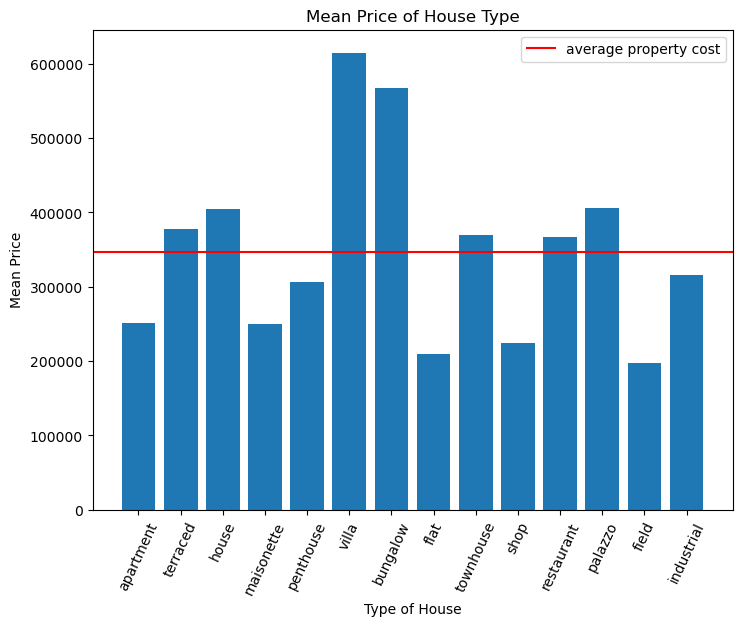

In [14]:
house_cost_df = data_df[['house', 'cost_eur']]


dict_house = {} 
for index in range(len(house_cost_df['house'])): # for each house type 
    if (house_cost_df.at[index,'house'] not in dict_house.keys()): # add the cost and the amount of house type 
        entry = {house_cost_df.at[index,'house'] : {'total_price' : house_cost_df.at[index,'cost_eur'], 'count' : 1}}
        dict_house.update(entry)
    else: #update respective field 
        dict_house[house_cost_df.at[index,'house']]['total_price'] += house_cost_df.at[index,'cost_eur']
        dict_house[house_cost_df.at[index,'house']]['count'] += 1 

        
for key in dict_house.keys():
    total_price = dict_house[key]['total_price']
    count = dict_house[key]['count']
    
    mean = total_price / count 
    dict_house[key].update({'mean' : mean})  #add the mean key for each house type 

x = [] 
y = [] 
 
for key in dict_house.keys():#get x and y axis 
    x.append(key)
    y.append(dict_house[key]['mean'])
    
mean_of_means = np.sum(y)/len(y) #mean of means 


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x,y) #bar chart 
ax.axhline(y=mean_of_means, label='average property cost', color='red') #add horz line 
plt.xticks(rotation=65)
#more details 
plt.title('Mean Price of House Type')
plt.xlabel('Type of House')
plt.ylabel('Mean Price')
plt.legend()
plt.show()

## Conclusion 2: Location is also a big influencer in determining house price 

Similarly, as above, we require that for each town, we generate the mean cost of property. Given the large amount of localities and some inconsistencies with data (for example specifying part of a town rather than the town itself), only localities with the greatest amount of listings are considered. </br>

Firstly for each town we generate a running total of the price and a counter for the times it was encountered, analogous to the above. For town's with a good amount of listings we generate their mean price into a new dictionary. The amount of listings required to make it into the new dictionary starts of high and gradually gets lower till the number of towns is at exactly 90, which will be the heatmap's size. 

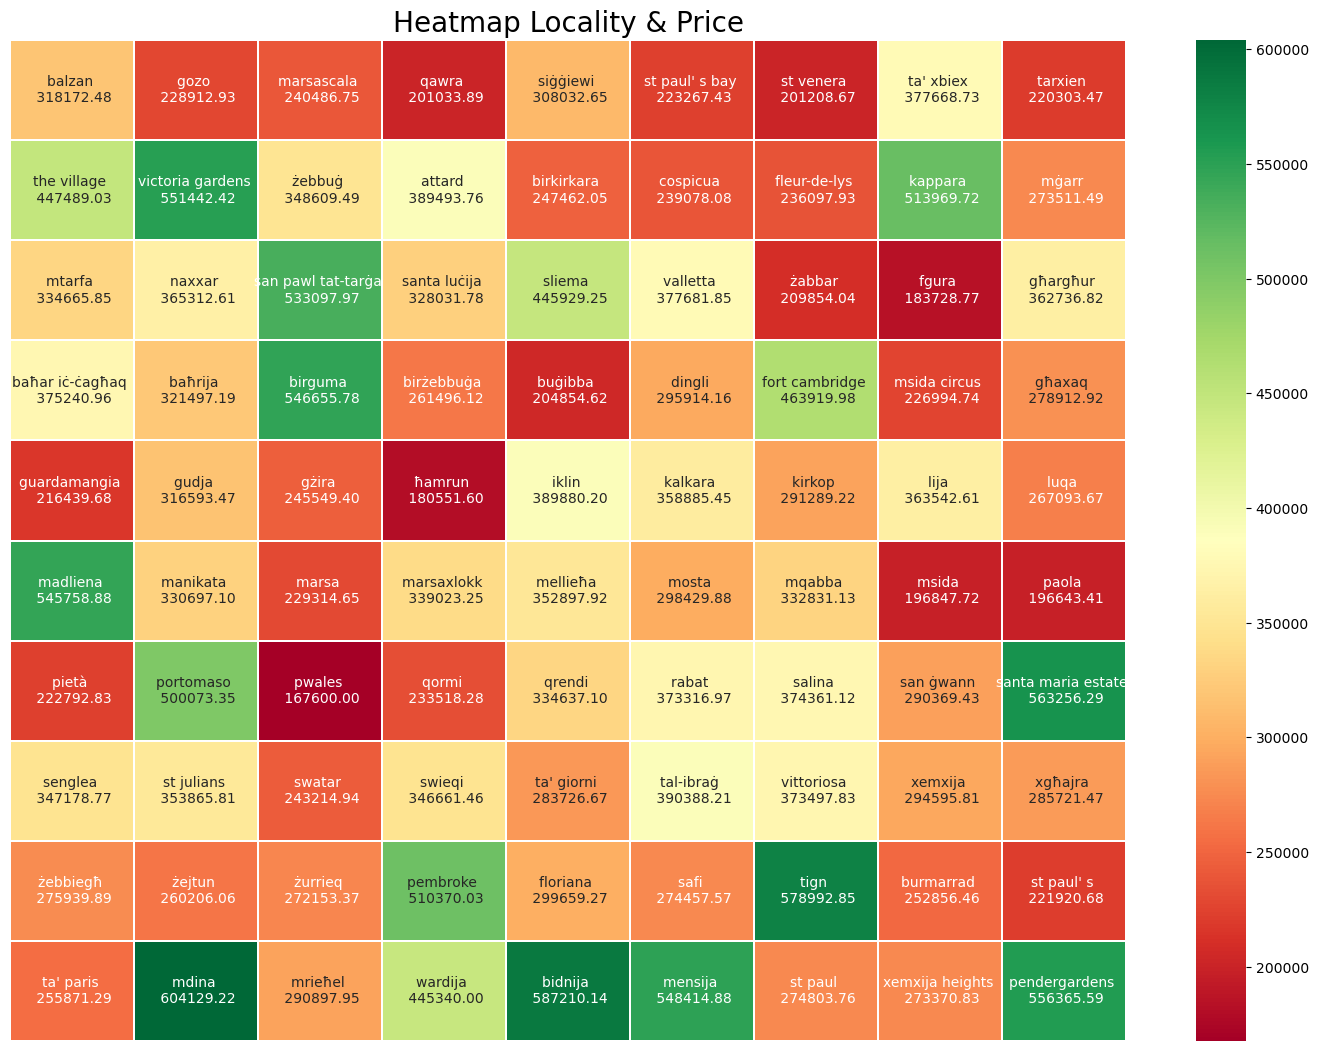

In [15]:
loc_price_df = data_df[['town', 'cost_eur']]

heatmap_dict = {} #create a dictionary with a location as key, and running total + count  as values 
for index in range(len(loc_price_df['town'])):
    if(loc_price_df.at[index, 'town'].strip() not in heatmap_dict.keys()):
        entry = {loc_price_df.at[index,'town'].strip() : {'total_price' : loc_price_df.at[index,'cost_eur'], 'count' : 1}}
        heatmap_dict.update(entry)
    else:
        heatmap_dict[loc_price_df.at[index,'town'].strip()]['total_price'] += loc_price_df.at[index,'cost_eur']
        heatmap_dict[loc_price_df.at[index,'town'].strip()]['count'] += 1
        
relevant_loc = {}   #consider only locations with a reasonable amount of listings, and take their mean price 
amount_of_listings = 100

while(len(relevant_loc.keys()) != 90): #for heatmap to be of size 90 - fixed heatmap size
    for key in heatmap_dict.keys(): 
        if(heatmap_dict[key]['count'] >= amount_of_listings): #We only want localities with a large number of entries (as opposed to smalls parts of a town )
            relevant_loc.update({key :  heatmap_dict[key]['total_price'] / heatmap_dict[key]['count']})
    amount_of_listings -=1 
        
        
df = pd.DataFrame(relevant_loc.values()) #create df 
df['Locations'] = list(relevant_loc.keys())
df.rename(columns = {0 : 'MeanPrice'}, inplace = True)


price_mean = (np.asarray(df['MeanPrice'])).reshape(10,9) #values for the heat map will consist of average price per locality  
labels = (np.asarray(["{0} \n {1:.2f}".format(loc, price) for loc, price in zip(df['Locations'],df['MeanPrice'])])).reshape(10,9)
#write the location and the value in the box 

fig, ax = plt.subplots(figsize=(18,13)) #plot 
sns.heatmap(price_mean,annot=labels,fmt="", cmap='RdYlGn', linewidth = 0.25, ax=ax) #heatmap 

ax.set_xticks([]) #remove the ticks (they do not convery any information)
ax.set_yticks([])
plt.title('Heatmap Locality & Price', fontsize = 20)
plt.show()




## Conclusion 3: Price of property is on the rise


In the below cell, we present the value of property across time, for each house type, along a average property cost across time for all the houses. </br>

We begin by discussing the subplots. As before, for each house type at a given year, we store the required data. The year, count, house type and running total. It is important to note that a key in this dictionary is the house type at that given year. Once this is formed the mean for each key is generated. Lastly, we form a dictionary with the house type as key. For the value this dictionary will now contain a list of means of that house type across the years. </br>

Each of these lists is then plotted in a subplot, with a unique color presented for each house type. Only house types that had at least one listing every year (2015-2022) were considered. After this the mean of all these means was taken for every year to see how the value of property flucutates across malta in this time range 

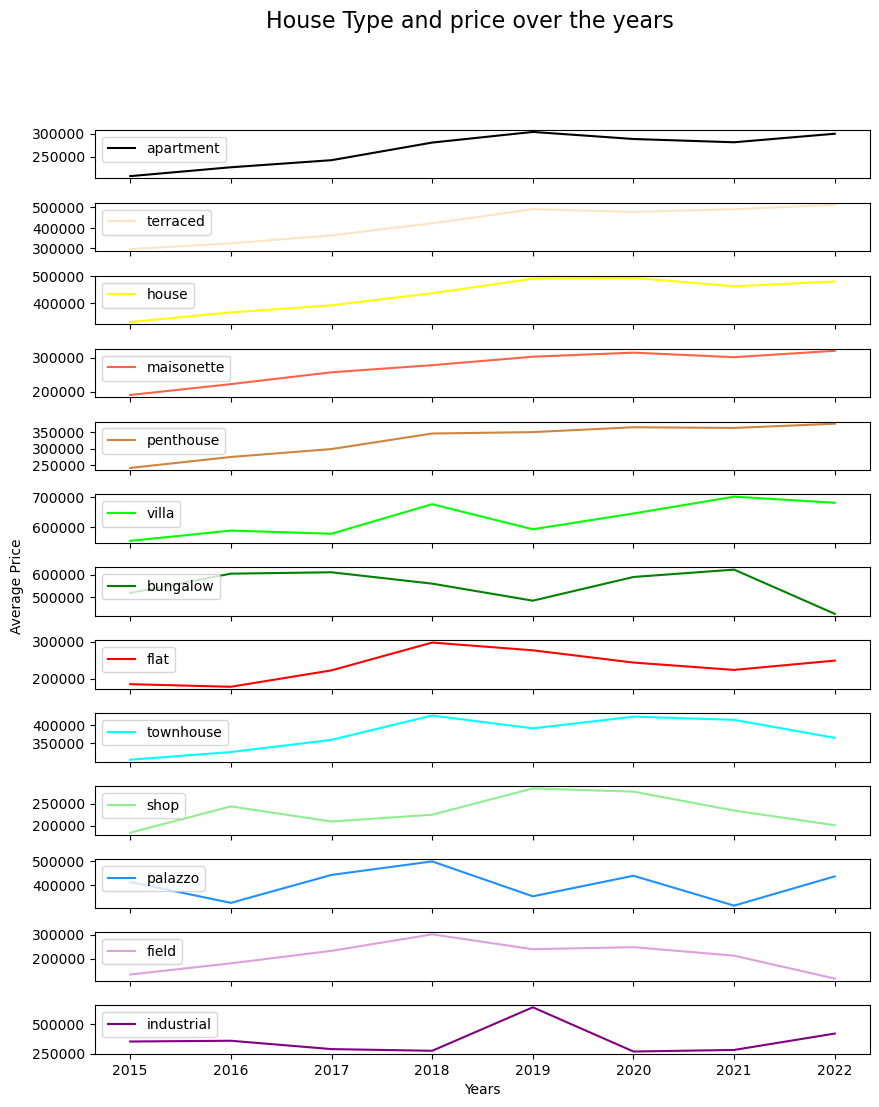

In [16]:
value_time_df = data_df[['cost_eur', 'house', 'year']]

years = list(set(value_time_df['year']))
years.sort() #get all the years 

line_graph_map = {}
for index in range(len(value_time_df['cost_eur'])): 
    
    year = value_time_df.at[index, 'year']
    house_type = value_time_df.at[index, 'house']
    key = str(year)+"_"+str(house_type) #key is a combination of the house type and it's year 
    
    if(key not in line_graph_map.keys()):
        #each entry will consist of a running total, the amount of times encounter, the year and the type of house 
        entry = {key : {'total' : value_time_df.at[index, 'cost_eur'], 'count' : 1, 'year': year, 'house' : house_type}}
        line_graph_map.update(entry)
    else: 
        #edit existing key
        line_graph_map[key]['total'] += value_time_df.at[index, 'cost_eur']
        line_graph_map[key]['count'] += 1 
        
for key in line_graph_map.keys(): #for each key, add a mean 
    mean = line_graph_map[key]['total'] / line_graph_map[key]['count']
    line_graph_map[key].update({'mean' : mean})


dict_of_house_prices = {} 
#creating a new dictionary of house types to a list of their respective means 
for key in line_graph_map.keys():
    if(line_graph_map[key]['house'] not in dict_of_house_prices):
        entry = {line_graph_map[key]['house'] : [line_graph_map[key]['mean']]}
        dict_of_house_prices.update(entry)
    else: 
        dict_of_house_prices[line_graph_map[key]['house']].append(line_graph_map[key]['mean'])

#each subplot will be assigned a color 
color_list = ['black', 'bisque', 'yellow', 'tomato', 'peru', 'lime', 'green', 'red',
             'cyan', 'lightgreen', 'dodgerblue', 'plum', 'purple']
color_counter = 0 


fig, ax = plt.subplots(nrows = 13, ncols = 1, figsize = (10,12), sharex = True) #generate the sub plots 
fig.suptitle("House Type and price over the years", fontsize=16)

for key in dict_of_house_prices.keys():
    if len(dict_of_house_prices[key]) == len(years): #only considering plots where they have entries for each year
        ax[color_counter].plot(years, dict_of_house_prices[key], label = key, color = color_list[color_counter])
        ax[color_counter].legend(loc = 'upper left')
        color_counter += 1 
            
#make figures nicer 
plt.xlabel('Years')
fig.text(0.04, 0.5, 'Average Price', va='center', rotation = 'vertical')
plt.subplots_adjust(hspace = 0.5)
plt.show()
        

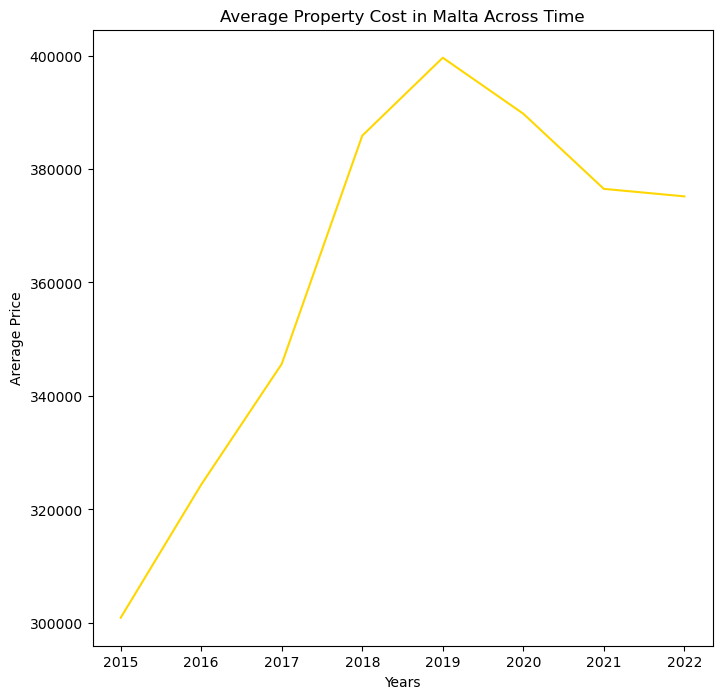

In [17]:
mean_of_properties = [] 

for index in range(len(years)):
    yearly_cost = [] 
    for key in dict_of_house_prices.keys():
        if(len(years) == len(dict_of_house_prices[key])):
            yearly_cost.append(dict_of_house_prices[key][index])
    mean_of_properties.append( np.sum(yearly_cost) / len(yearly_cost))

fig, ax = plt.subplots(figsize=(8,8))
plt.title('Average Property Cost in Malta Across Time')
plt.xlabel('Years')
plt.ylabel('Arerage Price')
plt.plot(years, mean_of_properties, color = 'gold')
plt.show()

## Conclusion 4: Property that has extra features (i.e a pool, yard, seaview etc) tends to be more expensive than property without 

We will perform the man whitney u test since the required assumptions are met. The dependent variable (cost) is continuous and the independent variable is split in two categories. The samples are independent by the design of the question, since it either belongs in one group or the other. Lastly, we need to show that the distributions are not normal and determine the nature of their shape since this effects the interpretion of the results. 

In [18]:
property_features_df = data_df[['cost_eur', 'extras']]

samples_dict = {"has_extras" : [], "no_extras" : [] } #collect the independent samples
for index in range(len(property_features_df['cost_eur'])):
    if(property_features_df.at[index, 'extras'] == 'N/A'):
        samples_dict['no_extras'].append(property_features_df.at[index, 'cost_eur'])
    else:
        samples_dict['has_extras'].append(property_features_df.at[index, 'cost_eur'])
        

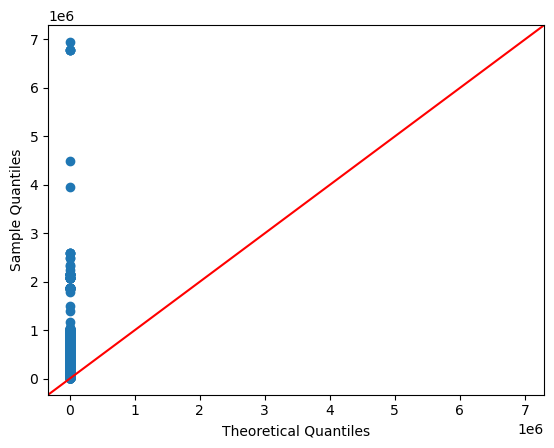

In [19]:
sm.qqplot(np.array(samples_dict['has_extras']), line = '45') #qqplot to show that data is not normal 
plt.show()

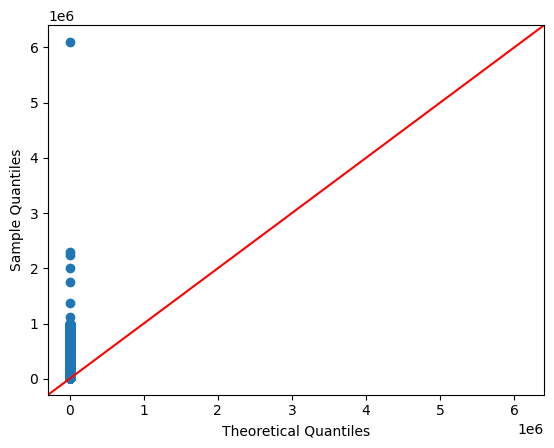

In [20]:
sm.qqplot(np.array(samples_dict['no_extras']), line = '45')
plt.show()

In [21]:
extras_property = kstest(samples_dict['has_extras'], 'norm') #kstest to further confirm this 
no_extras_property = kstest(samples_dict['no_extras'], 'norm')

if(extras_property.pvalue < 0.05 and no_extras_property.pvalue < 0.05):
    print("Data not normally distributed")
else:
    print("Failed to reject null hypothesis of the ks-test")

Data not normally distributed


### Data exhibits a right skew in both cases 

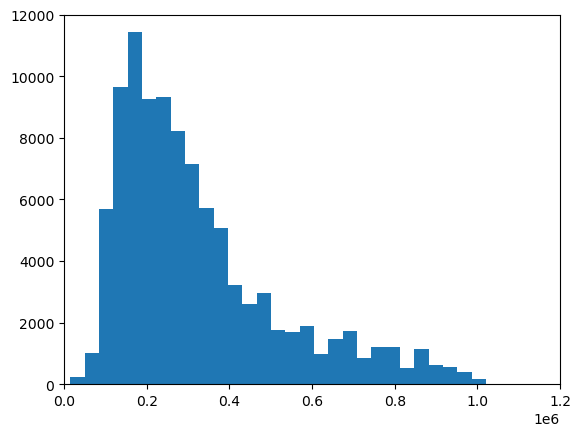

In [22]:
plt.hist(samples_dict['has_extras'], bins = 200)
plt.xlim(xmin=0,xmax=1200000)
plt.show()

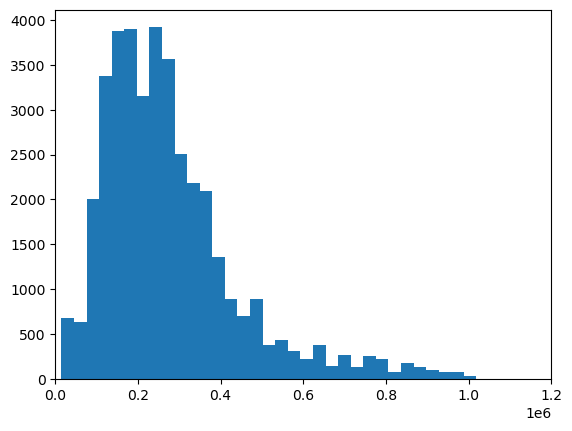

In [23]:
plt.hist(samples_dict['no_extras'], bins = 200)
plt.xlim(xmin=0,xmax=1200000)
plt.show()

### Man Whitney U test 

In [24]:
conc = mannwhitneyu(samples_dict['has_extras'],samples_dict['no_extras'],alternative='two-sided') 

if(conc.pvalue < 0.05):
    print("Significantly differ in their underlying distribution") 
else: 
    print("No difference in yield")
    

res = mannwhitneyu(samples_dict['no_extras'], samples_dict['has_extras'], alternative='less') 

if(res.pvalue < 0.05):
    print("The distribution of property with extra features is stochastically" 
          + " greater than the distribution of property without")

Significantly differ in their underlying distribution
The distribution of property with extra features is stochastically greater than the distribution of property without


# Correlation Between no of Bedrooms & Property price using Spearson's Rank Order Correlation 

We begin by noting that our observations are paired observations since for each house, there are the number of bedrooms, along with it's cost. Next our cost data can be considered as a continous interval, and the no of bedrooms can be considered as an ordinal scale with 10 levels. Lastly, we require a monotonic relationship. This can be seen by the scatter plot below 

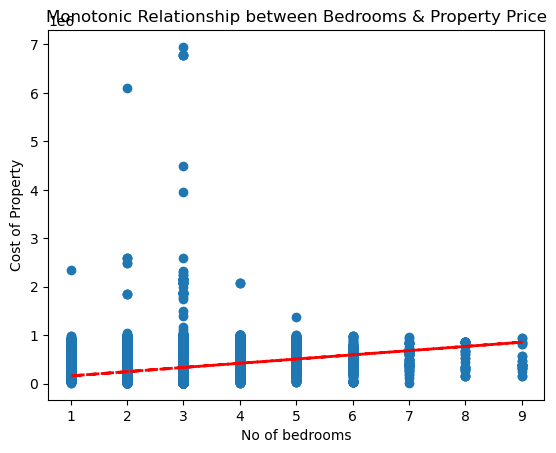

In [25]:
bedrooms = data_df['bedrooms']
cost = data_df['cost_eur']

m,c = np.polyfit(bedrooms, cost, 1) # fit to a line 

fig = plt.figure()
plt.scatter(bedrooms,cost) #generate the scatter 
plt.plot(bedrooms, np.multiply(m,bedrooms)+c, color = 'red', linestyle = '--', linewidth = 2) #plot the line 
plt.title('Monotonic Relationship between Bedrooms & Property Price')
plt.xlabel('No of bedrooms')
plt.ylabel('Cost of Property')
plt.show()

In [26]:
corr, p_value = spearmanr(bedrooms,cost) #run the stat test 
if p_value < 0.05:
    print("Correlation of: ", corr)
else:
    print("No correlation between these two variables")

Correlation of:  0.3269839420017405


# Statistical Analysis: Is there a difference between the price of property at 2015 in Malta to that in 2022 ? Which is statistically significantly more expensive?

In [27]:
property_cost_df = data_df[['cost_eur', 'year']]

property_dict = {'2015': [], '2022' : [] } 

for index in range(len(property_cost_df['cost_eur'])): #split the samples 
    year = property_cost_df.at[index, 'year']
    if(year == 2015):
        property_dict['2015'].append(property_cost_df.at[index, 'cost_eur'])
    elif(year == 2022):
        property_dict['2022'].append(property_cost_df.at[index, 'cost_eur'])

print("Listings in 2015: ", len(property_dict['2015']))
print("Listings in 2022: ", len(property_dict['2022']))
        
        


Listings in 2015:  23471
Listings in 2022:  7412


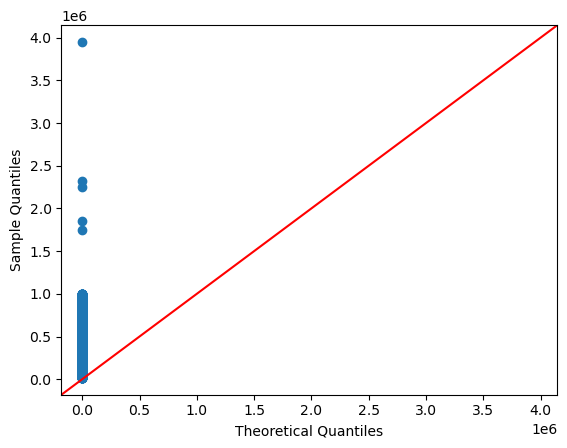

In [28]:
sm.qqplot(np.array(property_dict['2015']), line = '45') ##qqplot to show data is not normal 
plt.show()

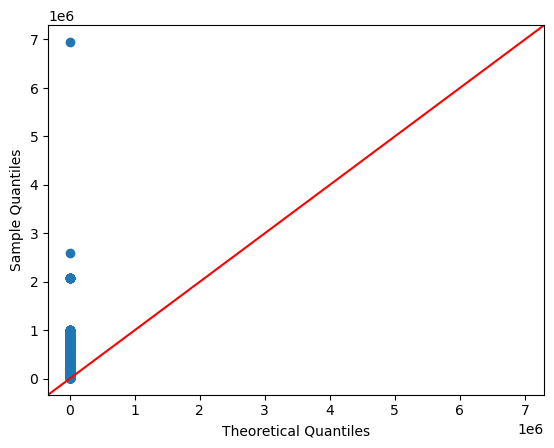

In [29]:
sm.qqplot(np.array(property_dict['2022']), line = '45')
plt.show()

In [30]:
data_2015 = kstest(property_dict['2015'], 'norm') #kstest to confirm this 
data_2022 = kstest(property_dict['2022'], 'norm')

if(data_2015.pvalue < 0.05 and data_2022.pvalue < 0.05):
    print("Data not normally distributed")
else:
    print("Failed to reject null hypothesis of the ks-test")

Data not normally distributed


## We will peform the non parametric Mann Whitney U test, since all assumptions are met. Firstly, our dependent variable (the cost) is on a continous scale. The independent variable (year) is two independent categorical groups, the year 2015 and the year 2022. Furthermore, the observations are by definition independent since they are taken from seperate years and hence do not affect each other. Lastly, the observations are not normally distributed. We require to determine whether they exhibit a similar shape or not since this effects the interpreation of our results. This is done below through the use of a histogram plot.

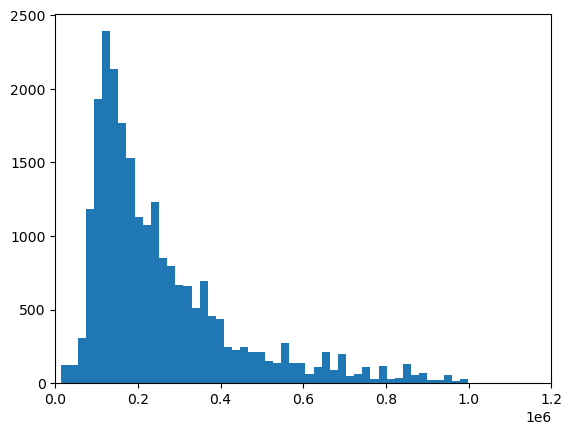

In [31]:
plt.hist(property_dict['2015'], bins=200)
plt.xlim(xmin=0,xmax=1200000)
plt.show()

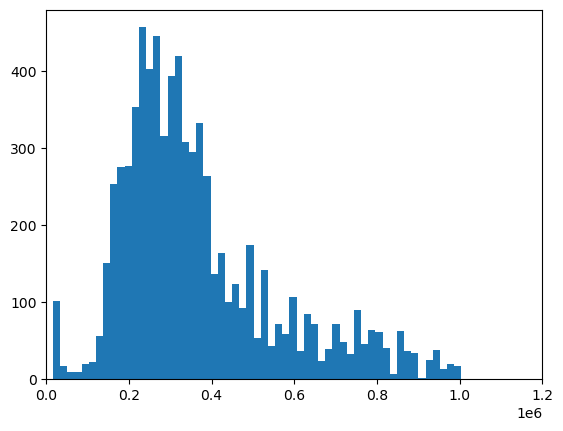

In [32]:
plt.hist(property_dict['2022'], bins=400)
plt.xlim(xmin=0,xmax=1200000)
plt.show()

In [33]:
conc = mannwhitneyu(property_dict['2015'],property_dict['2022'],alternative='two-sided') 

if(conc.pvalue < 0.05):
    print("Significantly differ in their underlying distribution") 
else: 
    print("No difference in yield")
    

res = mannwhitneyu(property_dict['2015'],property_dict['2022'],alternative='less') 

if(res.pvalue < 0.05):
    print("The distribution of 2022 is stochastically greater than the distribution of 2015")

Significantly differ in their underlying distribution
The distribution of 2022 is stochastically greater than the distribution of 2015


# Predictive model for the cost of property

We begin by splitting our data set into the target and features. Our features will include categoricala as well as continuous data. We begin by using OHE encodings for the categorical data. We prefer to do this over the label encodings since this might introduce a bias in the model, where a larger label might be viewed as better feature. However this makes the feature set much bigger, so we use pca to reduce dimensionality. Through a random search, using 4 fold cross validation, we optimize the parameters, and then train and test the model. RMSE and MAPE are used to evaluate the model. 

In [34]:
display(data_df)

cost_eur  bedrooms       house    extras        town  garage    year
0       152000.0       3.0   apartment  finished      balzan   False  2015.0
1       185000.0       3.0    terraced   terrace        gozo   False  2015.0
2       293000.0       4.0       house      pool        gozo   False  2015.0
3       145000.0       3.0  maisonette       N/A        gozo   False  2015.0
4        85000.0       2.0   apartment  finished  marsascala   False  2015.0
...          ...       ...         ...       ...         ...     ...     ...
136927  575000.0       3.0   townhouse  sea view    valletta   False  2022.0
136928   55000.0       3.0       house       N/A      żebbuġ   False  2022.0
136929  245000.0       3.0   apartment       N/A      żebbuġ   False  2022.0
136930  250000.0       3.0  maisonette      yard      żejtun   False  2022.0
136931  830000.0       3.0  maisonette       N/A  st julians   False  2022.0

[136932 rows x 7 columns]

# Split into target and features 

In [35]:
X = data_df.drop(columns = ['cost_eur'])
y = data_df['cost_eur']

display(X)
display(y)

bedrooms       house    extras        town  garage    year
0            3.0   apartment  finished      balzan   False  2015.0
1            3.0    terraced   terrace        gozo   False  2015.0
2            4.0       house      pool        gozo   False  2015.0
3            3.0  maisonette       N/A        gozo   False  2015.0
4            2.0   apartment  finished  marsascala   False  2015.0
...          ...         ...       ...         ...     ...     ...
136927       3.0   townhouse  sea view    valletta   False  2022.0
136928       3.0       house       N/A      żebbuġ   False  2022.0
136929       3.0   apartment       N/A      żebbuġ   False  2022.0
136930       3.0  maisonette      yard      żejtun   False  2022.0
136931       3.0  maisonette       N/A  st julians   False  2022.0

[136932 rows x 6 columns]

0         152000.0
1         185000.0
2         293000.0
3         145000.0
4          85000.0
            ...   
136927    575000.0
136928     55000.0
136929    245000.0
136930    250000.0
136931    830000.0
Name: cost_eur, Length: 136932, dtype: float64

### We know need to map all the non-numerical values of X, so that it can be fit into a neural network

In [36]:
X_ohe = X
categorical_columns = ['extras', 'house', 'town']

for col in categorical_columns:
    col_ohe = pd.get_dummies(X[col], prefix=col) #get one hot encodings 
    X_ohe = pd.concat((X_ohe, col_ohe), axis=1).drop(col, axis=1)

final_df = X_ohe 
final_df['garage'] = final_df['garage'].apply(lambda x: 1 if x == True else 0)

#NOTE: OHE are preffered over label encodings since these introduce higher numbers for which the model can 
#interpret as a 'btr' feature

df_norm = (final_df-final_df.min())/(final_df.max()-final_df.min()) #normalisation of all the data 

In [37]:
display(df_norm)
df_norm.info()

bedrooms  garage  year  extras_N/A  extras_balconies  extras_detached  \
0          0.250     0.0   0.0         0.0               0.0              0.0   
1          0.250     0.0   0.0         0.0               0.0              0.0   
2          0.375     0.0   0.0         0.0               0.0              0.0   
3          0.250     0.0   0.0         1.0               0.0              0.0   
4          0.125     0.0   0.0         0.0               0.0              0.0   
...          ...     ...   ...         ...               ...              ...   
136927     0.250     0.0   1.0         0.0               0.0              0.0   
136928     0.250     0.0   1.0         1.0               0.0              0.0   
136929     0.250     0.0   1.0         1.0               0.0              0.0   
136930     0.250     0.0   1.0         0.0               0.0              0.0   
136931     0.250     0.0   1.0         1.0               0.0              0.0   

        extras_finished  extras_furnished  extras_pool  extras_sea front  ...  \
0                   1.0               0.0          0.0               0.0  ...   
1                   0.0               0.0          0.0               0.0  ...   
2                   0.0               0.0          1.0               0.0  ...   
3                   0.0               0.0          0.0               0.0  ...   
4                   1.0               0.0          0.0               0.0  ...   
...                 ...               ...          ...               ...  ...   
136927              0.0               0.0          0.0               0.0  ...   
136928              0.0               0.0          0.0               0.0  ...   
136929              0.0               0.0          0.0               0.0  ...   
136930              0.0               0.0          0.0               0.0  ...   
136931              0.0               0.0          0.0               0.0  ...   

        town_żebbiġħ  town_żebbu  town_żebbug  town_żebbuġ  town_żejtun  \
0                0.0         0.0          0.0          0.0          0.0   
1                0.0         0.0          0.0          0.0          0.0   
2                0.0         0.0          0.0          0.0          0.0   
3                0.0         0.0          0.0          0.0          0.0   
4                0.0         0.0          0.0          0.0          0.0   
...              ...         ...          ...          ...          ...   
136927           0.0         0.0          0.0          0.0          0.0   
136928           0.0         0.0          0.0          1.0          0.0   
136929           0.0         0.0          0.0          1.0          0.0   
136930           0.0         0.0          0.0          0.0          1.0   
136931           0.0         0.0          0.0          0.0          0.0   

        town_żejtun g  town_żira  town_żira area  town_żonqor  town_żurrieq  
0                 0.0        0.0             0.0          0.0           0.0  
1                 0.0        0.0             0.0          0.0           0.0  
2                 0.0        0.0             0.0          0.0           0.0  
3                 0.0        0.0             0.0          0.0           0.0  
4                 0.0        0.0             0.0          0.0           0.0  
...               ...        ...             ...          ...           ...  
136927            0.0        0.0             0.0          0.0           0.0  
136928            0.0        0.0             0.0          0.0           0.0  
136929            0.0        0.0             0.0          0.0           0.0  
136930            0.0        0.0             0.0          0.0           0.0  
136931            0.0        0.0             0.0          0.0           0.0  

[136932 rows x 593 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136932 entries, 0 to 136931
Columns: 593 entries, bedrooms to town_żurrieq
dtypes: float64(593)
memory usage: 619.5 MB


## PCA

In [38]:
pca = PCA() #perform pca to reduce dimensionality 
pca.fit(df_norm) 
reduced_df = pca.transform(df_norm)

In [39]:
cut_off_perc = 99 
cum_var_arr = np.cumsum(pca.explained_variance_ratio_)*100 #cumulative variance array 
reduced_component_amount= 0 

for i in range(len(cum_var_arr)): 
    if(cum_var_arr[i] > cut_off_perc):#we find the amount of components needed to explain 99% of the varaince in the data 
        reduced_component_amount = i+1 
        print("No of components: ", reduced_component_amount, "Variance chosen: ", cut_off_perc)
        break; #we want the least amount of components 



No of components:  108 Variance chosen:  99


In [40]:
pca_df = pd.DataFrame(reduced_df)
to_remove = [len(pca_df.columns)-1 - i for i in range(len(pca_df.columns) - reduced_component_amount)]
pca_red = pca_df.drop(columns = to_remove) #remove uneeded cols 

## Split in test and train

In [41]:
X_train, X_test, y_train, y_test = train_test_split(pca_red,y, test_size = 0.2, random_state = 1)

## Optimize hyperparameters

In [42]:
parameters = {'hidden_layer_sizes':[(100,50,10), (100,50), (200,75,15)], 
              'activation': ['relu', 'tanh', 'logistic'], 
              'solver': ['adam', 'lbfgs', 'sgd'],
              'max_iter': [200, 500]
             }
regressor = MLPRegressor() 
kf = KFold(n_splits=4, shuffle = True) #4 fold cross val 

clf = RandomizedSearchCV(estimator = regressor, param_distributions = parameters, scoring='neg_mean_absolute_error', 
                         cv = kf, n_iter= 15, verbose=3, n_jobs = -1)
search = clf.fit(X_train, y_train)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


/home/wayne/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/wayne/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/wayne/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
S

/home/wayne/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/wayne/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/wayne/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/wayne/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/wayne/anaconda3/lib/python3.9/site-pac

[CV 3/4] END activation=tanh, hidden_layer_sizes=(100, 50), max_iter=200, solver=lbfgs;, score=-148010.970 total time= 3.5min
[CV 2/4] END activation=relu, hidden_layer_sizes=(100, 50), max_iter=500, solver=lbfgs;, score=-75088.855 total time= 6.1min
[CV 1/4] END activation=logistic, hidden_layer_sizes=(100, 50, 10), max_iter=500, solver=adam;, score=-308697.296 total time=74.5min
[CV 4/4] END activation=logistic, hidden_layer_sizes=(100, 50, 10), max_iter=500, solver=adam;, score=-310193.655 total time=68.7min
[CV 4/4] END activation=logistic, hidden_layer_sizes=(100, 50, 10), max_iter=200, solver=adam;, score=-311493.521 total time= 2.5min
[CV 1/4] END activation=relu, hidden_layer_sizes=(100, 50), max_iter=200, solver=lbfgs;, score=-78000.454 total time= 2.2min
[CV 3/4] END activation=relu, hidden_layer_sizes=(100, 50), max_iter=200, solver=lbfgs;, score=-79300.730 total time= 2.3min
[CV 2/4] END activation=logistic, hidden_layer_sizes=(100, 50), max_iter=500, solver=lbfgs;, score=-

/home/wayne/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/4] END activation=tanh, hidden_layer_sizes=(100, 50), max_iter=200, solver=lbfgs;, score=-144362.503 total time= 5.8min
[CV 3/4] END activation=relu, hidden_layer_sizes=(100, 50), max_iter=500, solver=lbfgs;, score=-75647.881 total time= 6.0min
[CV 2/4] END activation=logistic, hidden_layer_sizes=(100, 50, 10), max_iter=500, solver=adam;, score=-308153.736 total time=77.0min
[CV 1/4] END activation=logistic, hidden_layer_sizes=(200, 75, 15), max_iter=500, solver=sgd;, score=-148030.976 total time=  32.2s
[CV 2/4] END activation=logistic, hidden_layer_sizes=(200, 75, 15), max_iter=500, solver=sgd;, score=-146260.832 total time=  23.2s
[CV 3/4] END activation=logistic, hidden_layer_sizes=(200, 75, 15), max_iter=500, solver=sgd;, score=-147625.273 total time=  36.8s
[CV 4/4] END activation=logistic, hidden_layer_sizes=(200, 75, 15), max_iter=500, solver=sgd;, score=-147581.602 total time= 1.9min
[CV 1/4] END activation=relu, hidden_layer_sizes=(200, 75, 15), max_iter=500, solver=ada

/home/wayne/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/4] END activation=tanh, hidden_layer_sizes=(100, 50), max_iter=200, solver=lbfgs;, score=-147217.082 total time=  14.5s
[CV 4/4] END activation=tanh, hidden_layer_sizes=(100, 50), max_iter=200, solver=lbfgs;, score=-147525.813 total time=  15.0s
[CV 1/4] END activation=relu, hidden_layer_sizes=(100, 50), max_iter=500, solver=lbfgs;, score=-74757.982 total time= 6.6min
[CV 4/4] END activation=relu, hidden_layer_sizes=(100, 50), max_iter=500, solver=lbfgs;, score=-76134.984 total time= 5.8min
[CV 3/4] END activation=logistic, hidden_layer_sizes=(100, 50, 10), max_iter=500, solver=adam;, score=-311730.260 total time=82.4min
[CV 2/4] END activation=relu, hidden_layer_sizes=(200, 75, 15), max_iter=500, solver=adam;, score=-69058.179 total time=28.2min
[CV 4/4] END activation=relu, hidden_layer_sizes=(200, 75, 15), max_iter=500, solver=adam;, score=-70576.158 total time=36.5min
[CV 1/4] END activation=logistic, hidden_layer_sizes=(100, 50), max_iter=500, solver=lbfgs;, score=-147217.08

/home/wayne/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [43]:
print("Best Params: ", search.best_params_)
print("Best Score: ", search.best_score_)

Best Params:  {'solver': 'adam', 'max_iter': 500, 'hidden_layer_sizes': (200, 75, 15), 'activation': 'relu'}
Best Score:  -70541.23410483006


## Run the regressor on the optimized parameters 

In [44]:
optimized_reg = MLPRegressor() 
optimized_reg.set_params(**search.best_params_)
optimized_reg.fit(X_train,y_train)
y_pred = optimized_reg.predict(X_test)

/home/wayne/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


## Evaluation Methods 

In [45]:
print("Root mean squared error: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Median Absolute percentage error: ", mean_absolute_percentage_error(y_test, y_pred))
print("Mean absolute error: ", mean_absolute_error(y_test, y_pred))

Root mean squared error:  119514.84031508029
Median Absolute percentage error:  0.2708021593548163
Mean absolute error:  67348.7841317707
